# Atlas Based Segmentation

In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

/home/okozyn/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Normalize array from 0 to 1
def normalize(target_array):
    target_array -= target_array.min()
    normalized_array = np.divide(target_array, target_array.max())
    return normalized_array

# Read nii from path and normalize array from 0 to 1
def read_im(image_path):
    nii_img = nib.load(image_path)
    nii_data = nii_img.get_data()
    nii_data = normalize(nii_data)
    return nii_data, nii_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score

def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions  1) CSF (darkest) 3) GM (middle) 2) WM (light)
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    
    CSF_label = 1
    GM_label = 3
    WM_label = 2
    
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == CSF_label) * 1
    gt_CSF = (groundtruth_data == CSF_label) * 1
    seg_GM = (segmented_data == GM_label) * 1
    gt_GM = (groundtruth_data == GM_label) * 1
    seg_WM = (segmented_data == WM_label) * 1
    gt_WM = (groundtruth_data == WM_label) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()

## Read and show atlas

In [8]:
# put either 'mni' or 'our' (made from provided test images)
use_atlas = 'mni'

In [9]:
if use_atlas == 'our':
    # Path to template image
    mean_im = './our_atlas/mean_im.nii'
    # Path to atlases 
    GM_probs = './our_atlas/GM_probs.nii'
    WM_probs = './our_atlas/WM_probs.nii'
    CSF_probs = './our_atlas/CSF_probs.nii'
elif use_atlas == 'mni':
    # Path to template image
    mean_im = './MNITemplateAtlas/template.nii.gz'
    # Path to atlases 
    GM_probs = './MNITemplateAtlas/GM_probs.nii.gz'
    WM_probs = './MNITemplateAtlas/WM_probs.nii.gz'
    CSF_probs = './MNITemplateAtlas/CSF_probs.nii.gz'
else:
    raise ValueError("our_atlas values should be either mni' or 'our'")

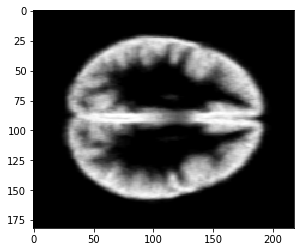

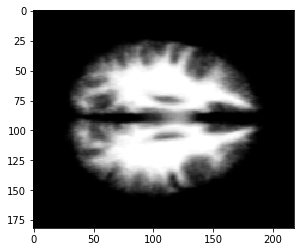

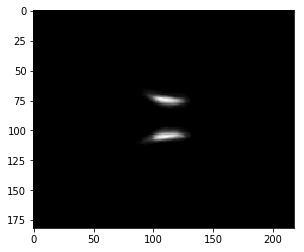

In [11]:
GM_atlas, _ = read_im(GM_probs)
WM_atlas, _ = read_im(WM_probs)
CSF_atlas, _ = read_im(CSF_probs)

plt.imshow(GM_atlas[:,:,100], cmap = "gray")
plt.show()
plt.imshow(WM_atlas[:,:,100], cmap = "gray")
plt.show()
plt.imshow(CSF_atlas[:,:,100], cmap = "gray")
plt.show()

# Segment one image using Atlas

In [12]:
if use_atlas == 'our':
    # Path to test image
    test_im = "./test-set/registration-results/our_templates/1003/result.1.nii"
elif use_atlas == 'mni':
    # Path to test image
    test_im = "./test-set/registration-results/mni_templates/1003/result.1.nii"

test_data, test_im = read_im(test_im)

In [13]:
# Key the labels already in the files??????? are these the right labels??? which does he want???
CSF_label = 1
GM_label = 3
WM_label = 2

In [14]:
# Assign GM, WM, CSF to voxel with highest probability
GM = GM_label * np.nan_to_num((GM_atlas > CSF_atlas) * (GM_atlas > WM_atlas))
WM = WM_label * np.nan_to_num((WM_atlas > CSF_atlas) * (WM_atlas > GM_atlas))
CSF = CSF_label * np.nan_to_num((CSF_atlas > WM_atlas) * (CSF_atlas > GM_atlas))
seg_im = GM + WM + CSF

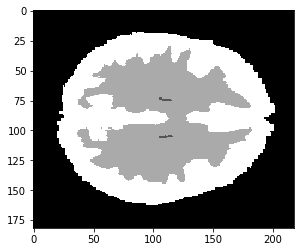

In [18]:
plt.imshow(seg_im[:,:,100], cmap = "gray")
plt.show()

# Segment All Images Using Atlas Only

In [19]:
if use_atlas == 'our':
    # Path to test image folder
    template_path = "./test-set/registration-results/our_templates/"
    atlas_path = "./test-set/registration-results/our_atlases/"
    result_path = "./test-set/segmentation-results/our-atlas-segmentation/"
elif use_atlas == 'mni':
    # Path to test image folder
    template_path = "./test-set/registration-results/mni_templates/"
    atlas_path = "./test-set/registration-results/mni_atlases/"
    result_path = "./test-set/segmentation-results/mni-atlas-segmentation/"

gt_path = "./test-set/testing-labels/"

onlydirs = [f for f in listdir(template_path) if isdir(join(template_path, f))]

all_dice = np.zeros((len(onlydirs),3))
# Key the labels already in the files
CSF_label = 1
GM_label = 3
WM_label = 2

for i, f in enumerate(onlydirs):
    _, template_img = read_im(join(template_path,f,'result.1.nii'))
    GM_atlas, _ = read_im(join(atlas_path, f,'gm','result.nii.gz'))
    WM_atlas, _ = read_im(join(atlas_path, f,'wm','result.nii.gz'))
    CSF_atlas, _ = read_im(join(atlas_path, f,'csf','result.nii.gz'))

    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((GM_atlas > CSF_atlas) * (GM_atlas > WM_atlas))
    WM = WM_label * np.nan_to_num((WM_atlas > CSF_atlas) * (WM_atlas > GM_atlas))
    CSF = CSF_label * np.nan_to_num((CSF_atlas > WM_atlas) * (CSF_atlas > GM_atlas))
    seg_im = GM + WM + CSF
    segmented_img = nib.Nifti1Image(seg_im, template_img.affine, template_img.header)

    # Calculate DICE
    path_gt = join(gt_path,f+"_3C.nii.gz")
    _, groundtruth_img = read_im(path_gt)
    all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segmented_img, groundtruth_img)

    # Make directory to save result seg
    new_dir = join(result_path,f)
    #os.mkdir(new_dir)
    #nib.save(segmented_img, join(new_dir,'atlas_seg.nii.gz'))

print(all_dice)

[[0.84789304 0.70059646 0.70958313]
 [0.84505166 0.6935822  0.7334566 ]
 [0.73551502 0.7243013  0.71835379]
 [0.76278171 0.71806565 0.73537541]
 [0.68199421 0.71659384 0.72170282]
 [0.80545079 0.71005765 0.72777276]
 [0.58192167 0.70766243 0.714818  ]
 [0.82668858 0.67915237 0.70232248]
 [0.85502941 0.67294968 0.71845339]
 [0.71241095 0.68079388 0.7198006 ]
 [0.77979512 0.67332047 0.74030939]
 [0.73485847 0.75056147 0.72229074]
 [0.86332689 0.67820103 0.70538036]
 [0.87558666 0.69064869 0.72804248]
 [0.61109654 0.6981994  0.70574383]
 [0.7540759  0.71057063 0.73058296]
 [0.58203369 0.73616945 0.72419775]
 [0.74201419 0.74207688 0.74449309]
 [0.59132836 0.7127679  0.72485565]
 [0.75307742 0.71905229 0.71879116]]


In [20]:
# Write DICE values to file
if use_atlas == 'our':
    out_dice_path = './dice-results/our_atlas_dice.csv'
elif use_atlas == 'mni':
    out_dice_path = './dice-results/mni_atlas_dice.csv'
    
with open(out_dice_path, 'w+') as out_f:
    out_f.write('img,csf,gm,wm,\n')
    for index, row in enumerate(all_dice): 
        out_f.write(onlydirs[index] + ',' + ','.join(str(j) for j in row) + ',\n')